In [1]:
!pip install netCDF4 --q

In [22]:
import netCDF4 as nc
from netCDF4 import Dataset
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import numpy as np
import pandas
import matplotlib as plt

In [23]:
#Uploading Data and Variables
data = nc.Dataset('/content/test1hr.nc')

rain_data = data["precip_liquid"]
rain_data = rain_data[:,[28],0,[17]]

wind_data = data['uvel']
wind_data = wind_data[:,[28],0,[17]]

temp_data = data['temp']
temp_data = temp_data[:,[28],0,[17]]

time = data['t']
time = np.asarray(time)

In [40]:
#Splitting Training/Testing Data
time_train,time_test,precip_train,precip_test  = train_test_split(time,rain_data )
time_train,time_test,uvel_train,uvel_test = train_test_split(time,wind_data)
time_train,time_test,temp_train,temp_test = train_test_split(time,temp_data)

training_data = [time_train, precip_train,uvel_train,temp_train]
testing_data = [time_test, precip_test,uvel_test,temp_test]
data = [time,rain_data, wind_data,temp_data]

In [41]:
#Normalizing Data
scaler = MinMaxScaler()
nsamples, nx, ny = precip_train.shape
rain_data_norm = precip_train.reshape((nsamples,nx*ny))
wind_data_norm = uvel_train.reshape((nsamples,nx*ny))
temp_data_norm = temp_train.reshape((nsamples,nx*ny))

precip_train = scaler.fit_transform(rain_data_norm)
uvel_train = scaler.fit_transform(wind_data_norm)
temp_train = scaler.fit_transform(temp_data_norm)

training_data = [precip_train,uvel_train,temp_train]
testing_data = [precip_test,uvel_test,temp_test]

In [42]:
#https://www.tensorflow.org/tutorials/generative/autoencoder
#TO DO: save best model
from tensorflow.keras.models import Model
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      keras.layers.Flatten(),
      keras.layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      keras.layers.Dense(784, activation='sigmoid'),
      #keras.layers.Reshape((28, 28))
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())

In [ ]:
print(time_test.shape, time_train.shape, precip_test.shape, precip_train.shape)

In [43]:
autoencoder.fit(time_train, training_data,
                epochs=10,
                shuffle=True,
                validation_data=(time_test, testing_data))
#TO DO: only print every 100 epochs

Epoch 1/10
11/11 [==============================] - 1s 22ms/step - loss: 0.3648 - val_loss: 0.2269
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.1552 - val_loss: 0.0760
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0432 - val_loss: 0.0101
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 10/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0010


Text(0.5, 1.0, 'u_vel')

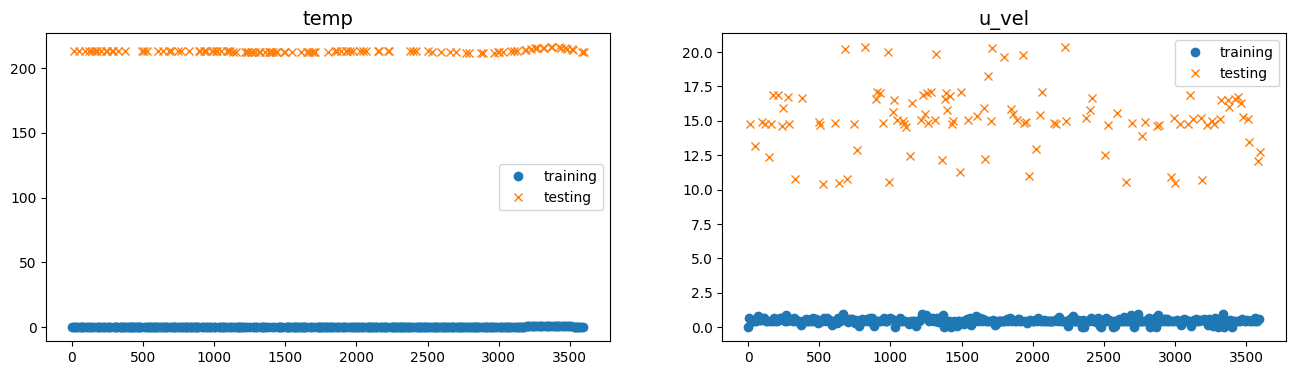

In [67]:
#TO DO : determine the best way to represent data
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize= (16,4))

training_data[0] = training_data[0].reshape(-1,)
training_data[1] = training_data[1].reshape(-1,)
training_data[2] = training_data[2].reshape(-1,)

testing_data[0] = testing_data[0].reshape(-1,)
testing_data[1] = testing_data[1].reshape(-1,)
testing_data[2] = testing_data[2].reshape(-1,)

ax[0].plot(time_train, training_data[2],'o',time_test, testing_data[2],'x',)
ax[0].legend(['training','testing'])
ax[0].set_title('temp',
              fontsize = 14)

ax[1].plot(time_train, training_data[1],'o',time_test, testing_data[1],'x',)
ax[1].legend(['training','testing'])
ax[1].set_title('u_vel',
              fontsize = 14)


#ax[2].plot(time_train.cpu().numpy(), training_data[2].cpu().numpy(),time_test.cpu().numpy(), testing_data[2].cpu().numpy(),'--',)
#ax[2].legend(['training','testing'])
#plt(time_train, precip_train, '--',  time_test, precip_test)